In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [2]:
credits_dataset = pd.read_csv('./tmdb-dataset/tmdb_5000_credits.csv')
credits_dataset.columns = ['id', 'title', 'cast', 'crew']

description_dataset = pd.read_csv('./tmdb-dataset/tmdb_5000_movies.csv')
description_dataset.columns = ['budget','genres','homepage','id','keywords','original_language','original_title','overview','popularity','production_companies','production_countries','release_date','revenue','runtime','spoken_languages','status','tagline','title','vote_average','vote_count']
description_dataset = description_dataset.drop(['homepage', 'original_title', 'original_language', 'production_countries', 'revenue', 'status', 'spoken_languages'], axis=1)

movies_dataset = pd.merge(credits_dataset, description_dataset, on='id')

# Plot Description-based filtering.

In [3]:
description_dataset['overview'].head(10)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
5    The seemingly invincible Spider-Man goes up ag...
6    When the kingdom's most wanted-and most charmi...
7    When Tony Stark tries to jumpstart a dormant p...
8    As Harry begins his sixth year at Hogwarts, he...
9    Fearing the actions of a god-like Super Hero l...
Name: overview, dtype: object

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tfidf = TfidfVectorizer(stop_words='english')

description_dataset['overview'] = description_dataset['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(description_dataset['overview'])

print(tfidf_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 125840 stored elements and shape (4803, 20978)>
  Coords	Values
  (0, 225)	0.3055534742040412
  (0, 3232)	0.19886014555883544
  (0, 13680)	0.34113864626811446
  (0, 11667)	0.25802679103767756
  (0, 5519)	0.2786343307183244
  (0, 12411)	0.2715536698060042
  (0, 13644)	0.2924861997916292
  (0, 19671)	0.24152597853522878
  (0, 12269)	0.17784472095302578
  (0, 19054)	0.23864791282019554
  (0, 7414)	0.21536095806128416
  (0, 13355)	0.25370721950251907
  (0, 14754)	0.2655670563059124
  (0, 795)	0.20840742038787768
  (0, 3545)	0.27493285363270825
  (1, 2999)	0.2310383461723521
  (1, 1733)	0.37466189442120984
  (1, 11220)	0.19862934058336526
  (1, 1951)	0.2916639832510735
  (1, 4854)	0.19967394354414503
  (1, 3843)	0.19195626583733216
  (1, 11025)	0.12158034118460531
  (1, 8674)	0.2809447973706985
  (1, 6069)	0.2948248727159851
  (1, 6016)	0.1966138874334538
  :	:
  (4802, 13234)	0.08384114424744893
  (4802, 19373)	0.114702524564064

### Συχνότητα λέξεων στο dataset, χρησιμοποιώντας το package WordCloud.

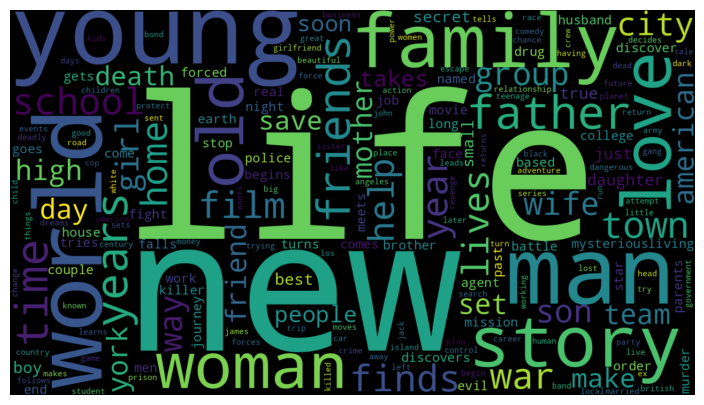

In [20]:
feature_names = tfidf.get_feature_names_out()
tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()  # average TF-IDF score per word
word_tfidf = dict(zip(feature_names, tfidf_scores))  # create word score dictionary

wordcloud = WordCloud(width=1280, height=720, background_color='black').generate_from_frequencies(word_tfidf)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
cosine_sim_descr = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim_descr

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02160533, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01488159, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02160533, 0.01488159, ..., 1.        , 0.01609091,
        0.00701914],
       [0.        , 0.        , 0.        , ..., 0.01609091, 1.        ,
        0.01171696],
       [0.        , 0.        , 0.        , ..., 0.00701914, 0.01171696,
        1.        ]])

In [21]:
indices = pd.Series(description_dataset.index, index=description_dataset['title']).drop_duplicates()

indices.head(1710)

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
Taking Woodstock                            1705
Miracle                                     1706
Dawn of the Dead                            1707
The Wedding Planner                         1708
Space Pirate Captain Harlock                1709
Length: 1710, dtype: int64

### Δημιουργία του Description-based algorithm, με εισαγωγή ονόματος ταινίας και εύρεση των 10 καλύτερων.

In [7]:
def descr_10_recommendations(title, cosine_sim_descr=cosine_sim_descr):
    similar_movies_idx = indices[title]

    similar_scores = list(enumerate(cosine_sim_descr[similar_movies_idx]))
    similar_scores = sorted(similar_scores, key=lambda x: x[1], reverse=True)
    similar_scores = similar_scores[1:11]

    similar_movie_indices = [i[0] for i in similar_scores]

    return description_dataset['title'].iloc[similar_movie_indices]
descr_10_recommendations("Fury")

787          The Great Raid
2386         One Man's Hero
2724               Downfall
680                   U-571
401      Enemy at the Gates
586       The Monuments Men
814     The Nutty Professor
4411                  Proud
4661         The Big Parade
889       The Thin Red Line
Name: title, dtype: object

# Metadata-based filtering.

In [8]:
movies_dataset.head(20)

,id,title_x,cast,crew,budget,genres,keywords,overview,popularity,production_companies,release_date,runtime,tagline,title_y,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,162.0,Enter the World of Pandora.,Avatar,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,169.0,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",2015-10-26,148.0,A Plan No One Escapes,Spectre,6.3,4466
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",2012-07-16,165.0,The Legend Ends,The Dark Knight Rises,7.6,9106
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",2012-03-07,132.0,"Lost in our world, found in another.",John Carter,6.1,2124
5,559,Spider-Man 3,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de...",258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...","[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",The seemingly invincible Spider-Man goes up ag...,115.699814,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",2007-05-01,139.0,The battle within.,Spider-Man 3,5.9,3576
6,38757,Tangled,"[{""cast_id"": 34, ""character"": ""Flynn Rider (vo...","[{""credit_id"": ""52fe46db9251416c91062101"", ""de...",260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...","[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",When the kingdom's most wanted-and most charmi...,48.681969,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2010-11-24,100.0,They're taking adventure to new lengths.,Tangled,7.4,3330
7,99861,Avengers: Age of Ultron,"[{""cast_id"": 76, ""character"": ""Tony Stark / Ir...","[{""credit_id"": ""55d5f7d4c3a3683e7e0016eb"", ""de...",280000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",When Tony Stark tries to jumpstart a dormant p...,134.279229,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...",2015-04-22,141.0,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767
8,767,Harry Potter and the Half-Blood Prince,"[{""cast_id"": 3, ""character"": ""Harry Potter"", ""...","[{""credit_id"": ""52fe4273c3a36847f801fab1"", ""de